In [40]:
# display the images
from PIL import Image
import matplotlib.pyplot as plt


In [41]:
%matplotlib inline

In [42]:


img_1_path = "kitchen/IMG20241128085234.jpg"
img_2_path = "kitchen/IMG20241128085236.jpg"
img_3_path = "kitchen/IMG20241128085238.jpg"

img_1 =  Image.open(img_1_path)
img_2 =  Image.open(img_2_path)
img_3 =  Image.open(img_3_path)

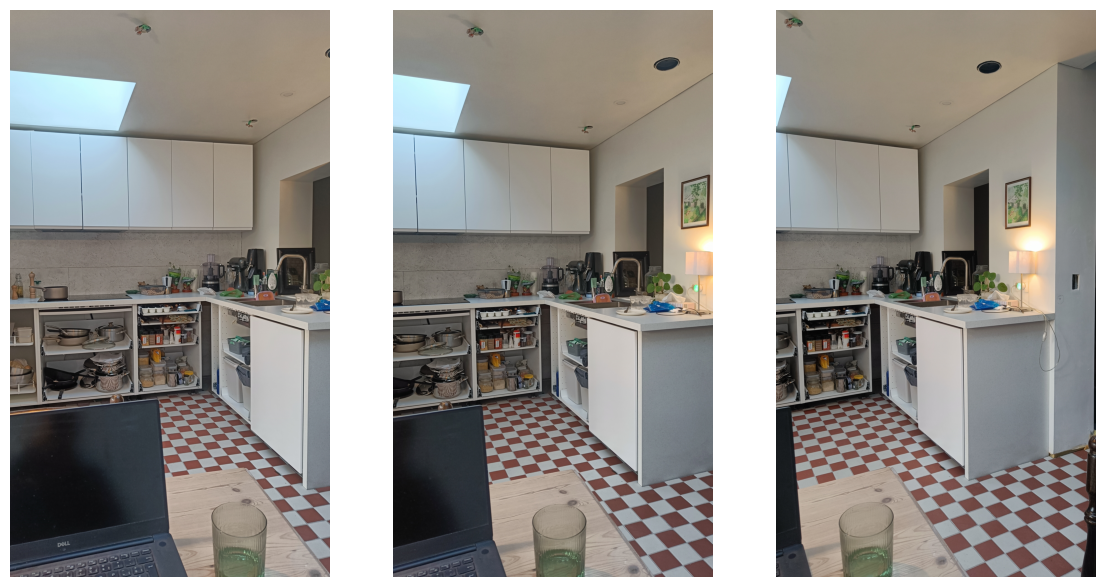

In [43]:

def display_images(imgs):
    fig = plt.figure(figsize=(14, 10))
    for i, img in enumerate(imgs):
        fig.add_subplot(1, len(imgs), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images([img_1, img_2, img_3])


In [44]:
# get SIFT and SURF features

import cv2
import numpy as np

def get_sift_features(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create(128)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

def get_surf_features(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    surf = cv2.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(gray, None)
    return kp, des


kp_1_sift, des_1_sift = get_sift_features(img_1)
kp_2_sift, des_2_sift = get_sift_features(img_2)
kp_3_sift, des_3_sift = get_sift_features(img_3)

# kp_1_surf, des_1_surf = get_surf_features(img_1)
# kp_2_surf, des_2_surf = get_surf_features(img_2)
# kp_3_surf, des_3_surf = get_surf_features(img_3)

print(f"Number of SIFT features in image 1: {len(kp_1_sift)}")
print(f"Number of SIFT features in image 2: {len(kp_2_sift)}")
print(f"Number of SIFT features in image 3: {len(kp_3_sift)}")



Number of SIFT features in image 1: 128
Number of SIFT features in image 2: 130
Number of SIFT features in image 3: 128


In [45]:

def draw_sift_features(img, keypoints):
    size = 15
    color = (0, 255, 0)
    img = np.array(img)
    annotated_img = img.copy()
    for i in range(len(keypoints)):
        x, y = keypoints[i].pt
        cv2.circle(annotated_img, (int(x), int(y)), size, color, -1)
    return Image.fromarray(annotated_img)
        
    
    

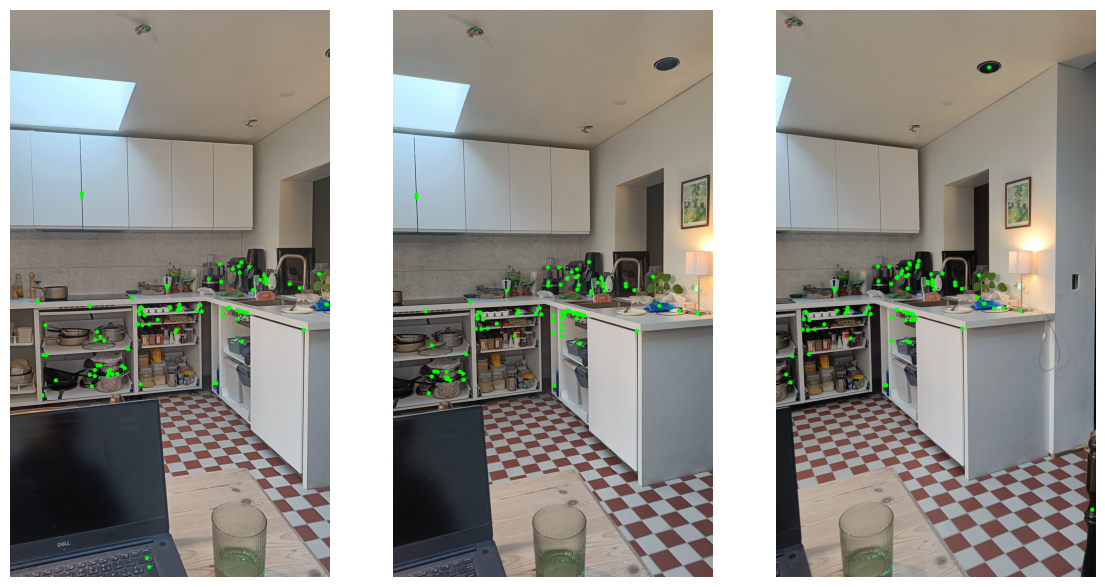

In [46]:
# display the keypoints

sift_img_1 = draw_sift_features(img_1, kp_1_sift)
sift_img_2 = draw_sift_features(img_2, kp_2_sift)
sift_img_3 = draw_sift_features(img_3, kp_3_sift)


display_images([sift_img_1, sift_img_2, sift_img_3])

In [56]:
# match keypoint features

def match_features(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=1)
    return matches

matches_1_2 = match_features(des_1_sift, des_2_sift)
matches_1_3 = match_features(des_1_sift, des_3_sift)

print(matches_1_2[0][0].distance)


279.72308349609375


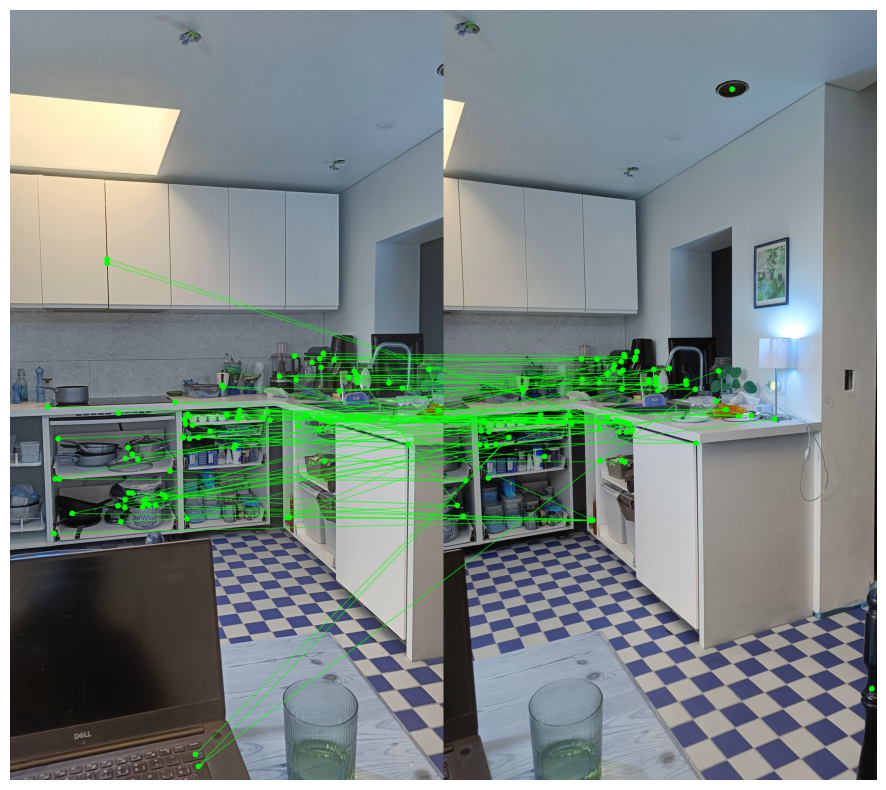

In [57]:
# display matches between two images

def draw_matches(img1, img2, kp1, kp2, matches):
    img1 = np.array(img1)
    img2 = np.array(img2)
    img1 = np.array(draw_sift_features(img1, kp1))
    img2 = np.array(draw_sift_features(img2, kp2))

    img = np.concatenate((img1, img2), axis=1)
    for i in range(len(matches)):
        idx1 = matches[i][0].queryIdx
        idx2 = matches[i][0].trainIdx
        x1, y1 = kp1[idx1].pt
        x2, y2 = kp2[idx2].pt
        x2 += img1.shape[1]
    
        color = (0, 255, 0)
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    return Image.fromarray(img)

match_img_1_3 = draw_matches(img_1, img_3, kp_1_sift, kp_3_sift, matches_1_3)

display_images([match_img_1_3])

In [ ]:
# interactive display

import ipywidgets as widgets
from IPython.display import display

def display_matches_interactive(img1, img2, kp1, kp2, matches):
    def update(n_matches=10):
        match_img = draw_matches(img1, img2, kp1, kp2, sorted(matches, key=lambda x: x[0].distance)[:n_matches])
        display(match_img)
    widgets.interact(update, n_matches=(0, len(matches), 1))

display_matches_interactive(img_1, img_3, kp_1_sift, kp_3_sift, matches_1_3)

interactive(children=(IntSlider(value=10, description='n_matches', max=128), Output()), _dom_classes=('widget-…

In [60]:
matches_1_3 = sorted(matches_1_3, key=lambda x: x[0].distance)[:60]

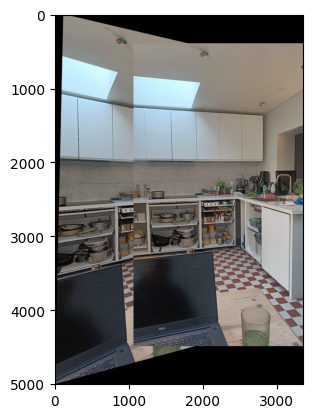

In [62]:
# compute homography

def compute_homography(kp1, kp2, matches):

    # filter matches with badest distance

    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H


H_1_3 = compute_homography(kp_1_sift, kp_3_sift, matches_1_3)
# stitch images

def stitch_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result

img_1 = cv2.imread(img_1_path)
img_2 = cv2.imread(img_2_path)
img_3 = cv2.imread(img_3_path)

stitched_img_1_2 = stitch_images(img_1, img_2, H_1_3)
plt.imshow(cv2.cvtColor(stitched_img_1_2, cv2.COLOR_BGR2RGB))